<a href="https://colab.research.google.com/github/shahansh22/diabetes-prediction-cnn/blob/main/InceptionV3_Glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
train_dir = '/content/drive/MyDrive/Glaucoma/Images'
train_csv = '/content/drive/MyDrive/Glaucoma/G1020.csv'
test_dir= '/content/drive/MyDrive/Glaucoma/ORIGA/Images'
test_csv= '/content/drive/MyDrive/Glaucoma/ORIGA/OrigaList.csv'

In [ ]:
# Define image dimensions
img_width, img_height = 244, 244 # Adjust based on your model's input size
# Read data from CSV
train= pd.read_csv(train_csv)
test=pd.read_csv(test_csv)
train_df=train.sample(frac=1).reset_index(drop=True)
train_df.head()

,imageID,binaryLabels
0,image_315.jpg,1
1,image_255.jpg,0
2,image_2550.jpg,0
3,image_483.jpg,0
4,image_912.jpg,0


<ipython-input-32-806792713419>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="binaryLabels", data=train, palette="GnBu_d")


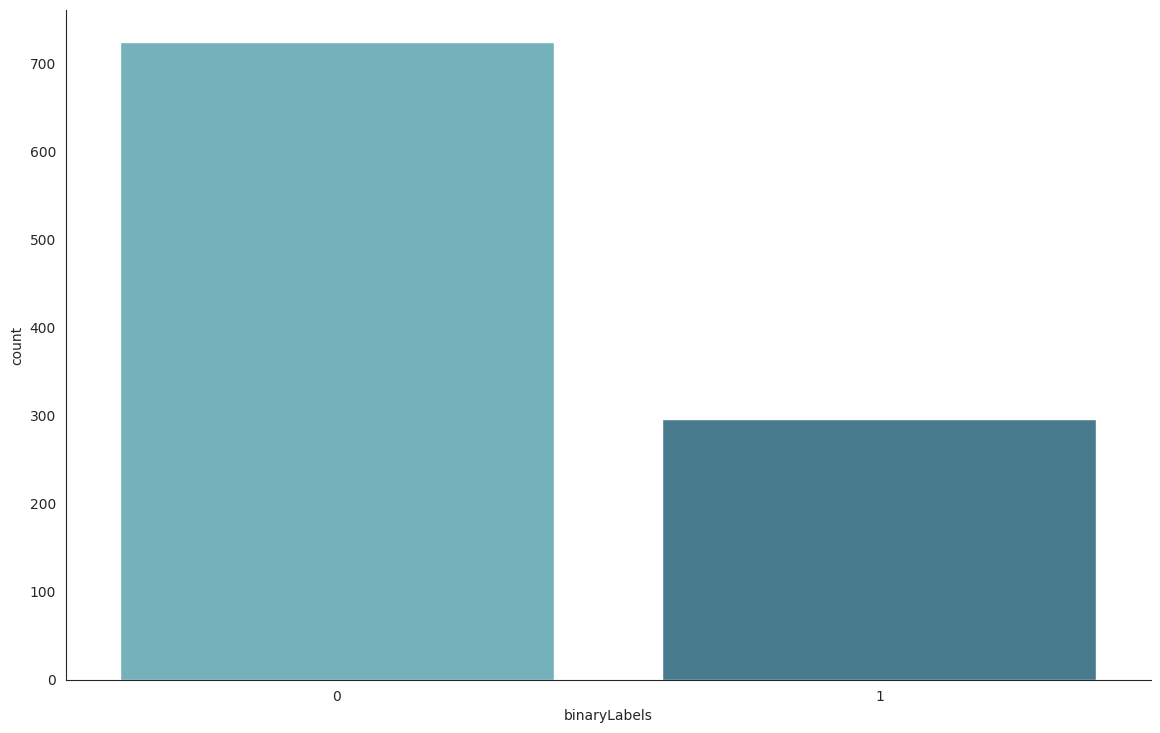

In [ ]:
# Label Class Distribution
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="binaryLabels", data=train, palette="GnBu_d")
sns.despine()
plt.show()

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['imageID'][:15]:
    img = cv2.imread("/content/drive/MyDrive/Glaucoma/Images/%s.jpg" % img_name)[...,[ 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()

TypeError: 'NoneType' object is not subscriptable

<Figure size 2000x2000 with 0 Axes>

In [ ]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and
    returns the a preprocessed image with
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (512,512))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

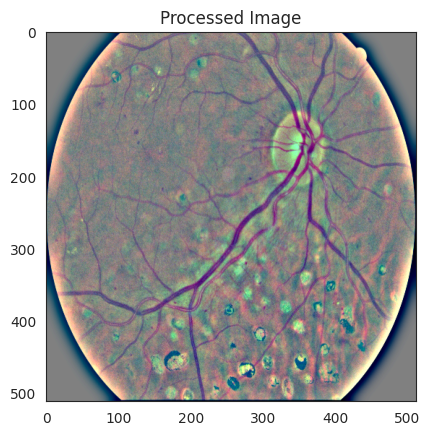

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the path to the training directory
TRAIN_IMG_PATH = '/content/drive/MyDrive/Glaucoma/Images'  # Adjust this path to where your images are stored

def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        if img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
            return img  # Return original image if cropped image is empty
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (512, 512))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    return image

# Example of loading and processing an image
image_name = 'image_0.jpg'  # Example image name
image_path = os.path.join(TRAIN_IMG_PATH, image_name)

image = cv2.imread(image_path)
processed_image = preprocess_image(image)
plt.imshow(processed_image)
plt.title("Processed Image")
plt.show()

In [ ]:
train_df['binaryLabels'] = train_df['binaryLabels'].astype('str')
test['level'] = test['level'].astype('str')
train.tail()
train_df.head()

,imageID,binaryLabels
0,image_315.jpg,1
1,image_255.jpg,0
2,image_2550.jpg,0
3,image_483.jpg,0
4,image_912.jpg,0


In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2,
                                 horizontal_flip=True
                                 )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="imageID",
    y_col="binaryLabels",
    batch_size=32,
    class_mode="categorical",
    target_size=(img_height,img_width ),
    shuffle=True,
    subset='training'
    )

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="imageID",
    y_col="binaryLabels",
    batch_size=32,
    class_mode="categorical",
    target_size=(img_height,img_width),
    shuffle=True,
    subset='validation'
    )

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = test_dir,
        x_col="image",
        target_size=(img_height, img_width),
        batch_size=1,
        shuffle=False,
        class_mode=None,
        )

Found 816 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.
Found 650 validated image filenames.


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Choose pre-trained model (InceptionV3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Create a new model on top of the InceptionV3 base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2,activation='softmax')
])

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
batch_size=32
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras import optimizers
for layer in model.layers:
    layer.trainable = True

#es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

callback_list = [rlrop]
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # You can adjust the number of epochs as needed
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
).history

Epoch 1/10
25/25 [==============================] - 599s 22s/step - loss: 0.6708 - accuracy: 0.6760 - val_loss: 0.6941 - val_accuracy: 0.7135
Epoch 2/10
25/25 [==============================] - 494s 20s/step - loss: 0.5609 - accuracy: 0.7258 - val_loss: 0.9804 - val_accuracy: 0.7292
Epoch 3/10
25/25 [==============================] - 494s 20s/step - loss: 0.4275 - accuracy: 0.8061 - val_loss: 1.3946 - val_accuracy: 0.7188
Epoch 4/10
25/25 [==============================] - 485s 19s/step - loss: 0.2969 - accuracy: 0.8941 - val_loss: 2.4572 - val_accuracy: 0.7135
Epoch 5/10
25/25 [==============================] - 496s 20s/step - loss: 0.2355 - accuracy: 0.9145 - val_loss: 2.3057 - val_accuracy: 0.7188
Epoch 6/10
25/25 [==============================] - 481s 19s/step - loss: 0.1898 - accuracy: 0.9222 - val_loss: 2.3186 - val_accuracy: 0.7344
Epoch 7/10
25/25 [==============================] - 498s 20s/step - loss: 0.1214 - accuracy: 0.9592 - val_loss: 2.1979 - val_accuracy: 0.7188
Epoch 

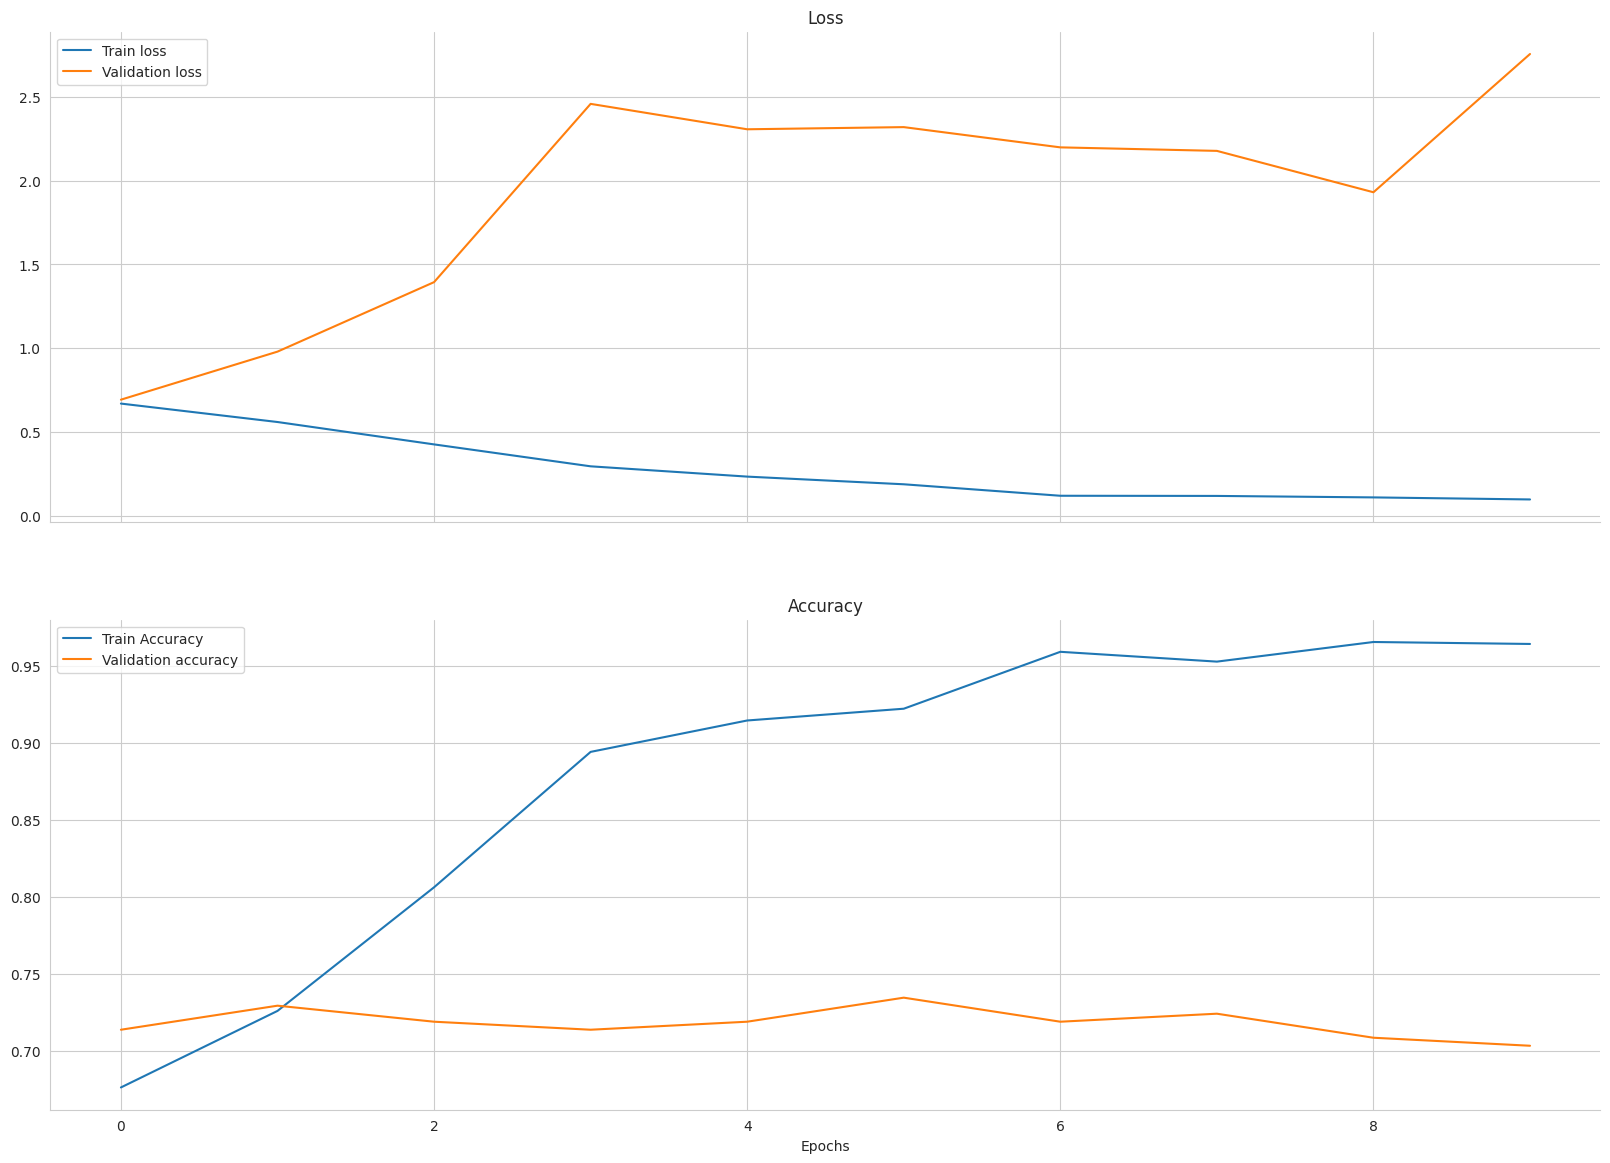

In [ ]:
# Model loss graph
history = {
    'loss': history['loss'],
    'val_loss': history['val_loss'],
    'accuracy': history['accuracy'],
    'val_accuracy': history['val_accuracy']
}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
import numpy as np
# Predict classes of test images
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Load true classes from CSV
test_csv = pd.read_csv('/content/drive/MyDrive/Glaucoma/ORIGA/OrigaList.csv')
true_classes = test_csv['level'].values

650/650 [==============================] - 122s 188ms/step


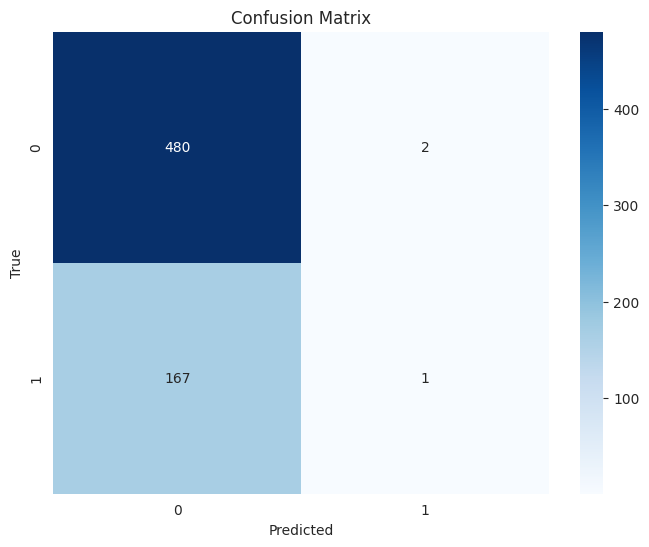

In [ ]:
import seaborn as sns
# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:\n", classification_report(true_classes,predicted_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85       482
           1       0.33      0.01      0.01       168

    accuracy                           0.74       650
   macro avg       0.54      0.50      0.43       650
weighted avg       0.64      0.74      0.63       650

